# Cassini Cosmic Dust Analyzer - Project 1: Calibrating CDA

## Part 4: How to train on imbalanced regression data ...

Last time we created our very first Neural Network to conduct a calibration task on our data! But ... our data points that are scattered in a quite "imbalanced" way need to be considered during training, validation and testing. How can we ensure that the data splitting is done properly? That's today's scope!

Additionally, we got 2 metrics that are important to check the quality of our model: the RSME and the MAE. Cool ... but ... these values apply to ALL training data at once. How can we compute the deviations depending on its position?

After this tutorial we will do some "fine adjustments" of our model itself. We will use Keras-Tuner to check more solution spaces and conduct a k-fold training to get a better picture of the losses and metrics. Then, we will "leave" Jupyter-Lab to create some more high-performance plottling routines.

And finally, we will publish our results in a small library ... to use it later!

## Read in the data

In [1]:
# Import default libraries
import pathlib
import zipfile

# Import installed libraries
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import sklearn.model_selection
import tensorflow as tf

# Matplotlib darkmode
#plt.style.use('dark_background')

# Styling
plt.rcParams.update({
    "font.size": 14
})

In [2]:
# Read in the level 1 data
cal_df = pd.read_pickle("data/level1/CDA__CAT_IID_cal_data.pkl")

In [3]:
# In our example we'll only consider IID QI data
iid_qi_cal_df = cal_df.loc[(cal_df["TAR"] == "IID")
                           & (cal_df["QI_CHARGE"] > 0.0)
                           & (cal_df["QI_TR"] > 0.0)].copy()

# Adding the LOG10 scaled data of the QI channel
iid_qi_cal_df.loc[:, "QI_LOG10_CHARGE"] = np.log10(iid_qi_cal_df["QI_CHARGE"])

# Considering only "relevant" data: rise time, log10 charge and the velocity
iid_qi_cal_df = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL"]]

In [4]:
iid_qi_cal_df

,QI_TR,QI_LOG10_CHARGE,PSU_VEL
829,57.00,1.642941,4.09
830,54.00,1.629768,4.07
831,59.16,1.687190,4.10
832,59.50,1.708315,4.11
833,55.67,2.114961,4.07
...,...,...,...
3741,32.17,1.113258,7.93
3742,28.84,1.213491,8.23
3743,37.50,1.125104,8.21
3744,19.33,1.167178,7.84


In [5]:
iid_qi_cal_df.describe()

,QI_TR,QI_LOG10_CHARGE,PSU_VEL
count,1634.000000,1634.000000,1634.000000
mean,40.512815,1.416504,10.036346
std,16.762827,0.524261,9.302421
min,0.340000,-0.335588,1.590000
25%,26.500000,1.066341,4.230000
50%,44.000000,1.365587,7.030000
75%,53.170000,1.804166,11.075000
max,89.830000,2.851513,69.700000


## Calibration data distribution

Text(0.5, 0, 'PSU velocity in km/s')

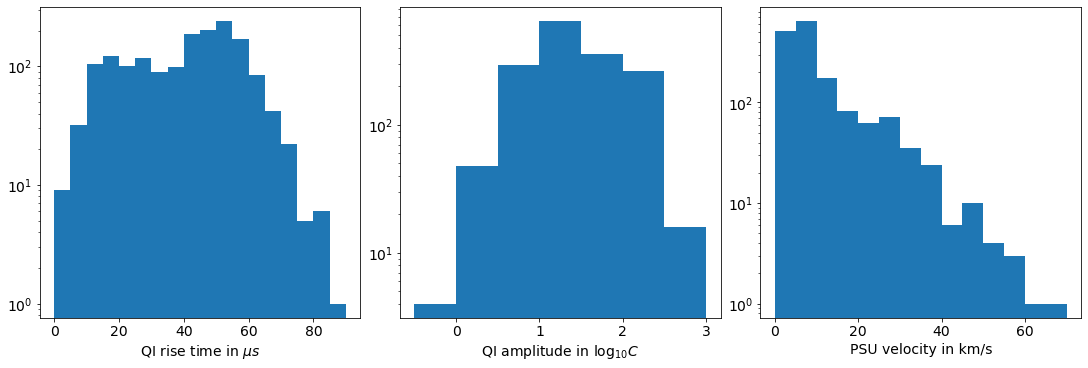

In [6]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', sharey=False, figsize=(15,5))

# Add the QI Rise time
ax1.hist(iid_qi_cal_df["QI_TR"], bins=np.arange(0,95,5))
ax1.set_yscale("log")
ax1.set_xlabel("QI rise time in " + r"$\mu s$")

# Add the QI Amplitude
ax2.hist(iid_qi_cal_df["QI_LOG10_CHARGE"], bins=np.arange(-0.5,3.5,0.5))
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} C$")

# Add the PSU velocity
ax3.hist(iid_qi_cal_df["PSU_VEL"], bins=np.arange(0,75,5))
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

## Calibration data weightning

In [7]:
psu_vel_bins = np.arange(0,95,5)
qi_tr_bins = np.arange(0,100,10)
qi_ampl_bins = np.arange(-0.5,3.5,0.5)

psu_entries, _ = np.histogram(iid_qi_cal_df["PSU_VEL"], bins=psu_vel_bins)
qi_tr_entries, _ = np.histogram(iid_qi_cal_df["QI_TR"], bins=qi_tr_bins)
qi_ampl_entries, _ = np.histogram(iid_qi_cal_df["QI_LOG10_CHARGE"], bins=qi_ampl_bins)

In [8]:
qi_ampl_entries

array([  4,  48, 293, 649, 361, 263,  16])

In [9]:
qi_ampl_entries = 1.0 / (qi_ampl_entries / np.sum(qi_ampl_entries))
qi_tr_entries = 1.0 / (qi_tr_entries / np.sum(qi_tr_entries))
qi_ampl_entries = 1.0 / (qi_ampl_entries / np.sum(qi_ampl_entries))

In [10]:
qi_tr_entries

array([ 39.85365854,   7.19823789,   7.46118721,   8.69148936,
         4.20051414,   3.98536585,  12.96825397,  60.51851852,
       233.42857143])

In [11]:
# We add now a sampling weight column that simply provides the number of samples per rise time,
# amplitude and velocity bin
iid_qi_cal_df.loc[:, "PSU_VEL_sample_weight"] = \
    iid_qi_cal_df["PSU_VEL"].apply(lambda x:
                                       psu_entries[np.where(x -  psu_vel_bins > 0,
                                                            x - psu_vel_bins, np.inf).argmin()])

iid_qi_cal_df.loc[:, "QI_TR_sample_weight"] = \
    iid_qi_cal_df["QI_TR"].apply(lambda x:
                                     qi_tr_entries[np.where(x - qi_tr_bins > 0,
                                                            x - qi_tr_bins, np.inf).argmin()])

iid_qi_cal_df.loc[:, "QI_LOG10_CHARGE_sample_weight"] = \
    iid_qi_cal_df["QI_LOG10_CHARGE"].apply(lambda x:
                                               qi_ampl_entries[np.where(x - qi_ampl_bins > 0,
                                                                        x - qi_ampl_bins, np.inf).argmin()])

In [12]:
# Convert the pandas dataframe to a numpy array
iid_qi_vel = iid_qi_cal_df[["QI_TR", "QI_LOG10_CHARGE", "PSU_VEL",
                            "QI_TR_sample_weight", "QI_LOG10_CHARGE_sample_weight",
                            "PSU_VEL_sample_weight"]].values

## Training data splitting

In [13]:
# Split the data in training and testing data ... and then the training data into ... training and
# validation (to preserve the stratification)
X_pre_train, X_pre_test = sklearn.model_selection.train_test_split(iid_qi_vel,
                                                               stratify=iid_qi_vel[:, 5:],
                                                               test_size=0.2)

# Extract now the testing data
X_test = X_pre_test[:, :2]
y_test = X_pre_test[:, 2]

In [14]:
X_pre_train

array([[ 70.67      ,   1.00977798,   8.2       ,  60.51851852,
        223.81381494, 647.        ],
       [  5.        ,   1.3989984 ,  18.6       ,  39.85365854,
        223.81381494,  82.        ],
       [ 67.83      ,   0.79680807,   9.2       ,  12.96825397,
        101.04383325, 647.        ],
       ...,
       [ 65.17      ,   0.79680807,   4.43      ,  12.96825397,
        101.04383325, 512.        ],
       [ 45.        ,   2.34485776,   3.19      ,   4.20051414,
         90.69804827, 512.        ],
       [ 10.5       ,   1.61972344,  21.2       ,   7.19823789,
        124.49427919,  63.        ]])

In [15]:
# Create now stratified validation and the final training data
X_pre_train, X_pre_val = sklearn.model_selection.train_test_split(X_pre_train,
                                                                  stratify=X_pre_train[:, 5:],
                                                                  test_size=0.25)

# Extract
X_train = X_pre_train[:, :2]
y_train = X_pre_train[:, 2]

X_val = X_pre_val[:, :2]
y_val = X_pre_val[:, 2]

Text(0.5, 0, 'PSU velocity in km/s')

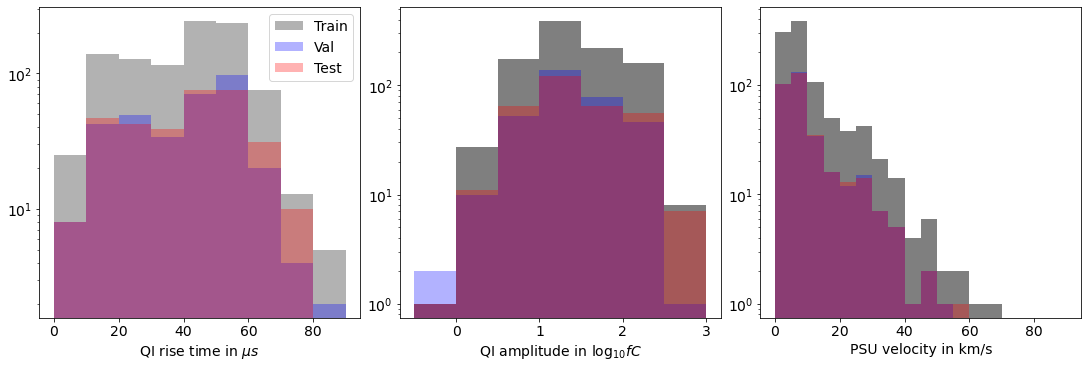

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, layout='constrained', sharey=False, figsize=(15,5))

# Add the QI Rise time
ax1.hist(X_train[:, 0], bins=qi_tr_bins, alpha=0.3, color="black", label="Train")
ax1.hist(X_val[:, 0], bins=qi_tr_bins, alpha=0.3, color="blue", label="Val")
ax1.hist(X_test[:, 0], bins=qi_tr_bins, alpha=0.3, color="red", label="Test")
ax1.set_yscale("log")
ax1.set_xlabel("QI rise time in " + r"$\mu s$")

ax1.legend(loc="upper right")

# Add the QI Amplitude
ax2.hist(X_train[:, 1], bins=qi_ampl_bins, alpha=0.5, color="black")
ax2.hist(X_val[:, 1], bins=qi_ampl_bins, alpha=0.3, color="blue")
ax2.hist(X_test[:, 1], bins=qi_ampl_bins, alpha=0.3, color="red")
ax2.set_yscale("log")
ax2.set_xlabel("QI amplitude in " + r"$\log_{10} fC$")

# Add the PSU velocity
ax3.hist(y_train, bins=psu_vel_bins, alpha=0.5, color="black")
ax3.hist(y_val, bins=psu_vel_bins, alpha=0.3, color="blue")
ax3.hist(y_test, bins=psu_vel_bins, alpha=0.3, color="red")
ax3.set_yscale("log")
ax3.set_xlabel("PSU velocity in km/s")

## Scaling data

In [17]:
# We scale the data now by applying a StandardScaler that substracts the mean and divides by the
# standard deviation
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_scaler = sklearn.preprocessing.StandardScaler()
y_scaler = sklearn.preprocessing.StandardScaler()

# Normaly the scaling is applied on the training data that is later splitted into train and val
# data during the training process (fit function). So to stay consistent with last time, we need to
# train the scaller based on training and valiation data
X_scaler.fit(np.vstack([X_train, X_val]))
X_train_scaled = X_scaler.transform(X_train)
X_val_scaled = X_scaler.transform(X_val)
X_test_scaled = X_scaler.transform(X_test)

y_scaler.fit(np.vstack([y_train, y_val]))
y_train_scaled = y_scaler.transform(y_train)
y_val_scaled = y_scaler.transform(y_val)
y_test_scaled = y_scaler.transform(y_test)

## Machine Learning Training

2023-04-20 22:52:23.439487: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


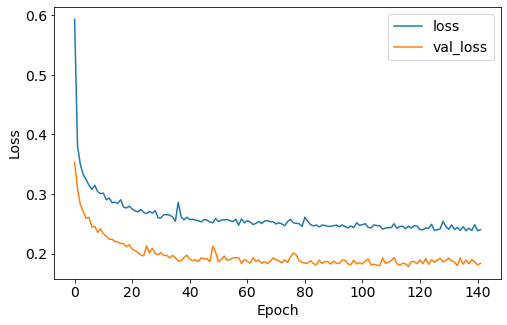

In [18]:
# We create a simple neural network with only 2 hidden layer in this first regression tutorial

# Create a callback to stop the training after reaching a generalization optimum
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               patience=25,
                                               restore_best_weights=True)

# Input shape is 2: rise time and charge
inputs = tf.keras.Input(shape=(2,),
                        name="iid_qi_data",)

# 2 Hidden Layers
layer = tf.keras.layers.Dense(units=64, activation="relu",)(inputs)
layer = tf.keras.layers.Dense(units=32, activation="relu",)(layer)

# Output Layers has only 1 unit, since we map our results to the velocity values
output = tf.keras.layers.Dense(units=1, name="psu_vel",)(layer)

# There are miscellaneous keras APIs to create a model, like Sequential(). I'd recommend to work
# directly with Model(). In this case Sequential() would be good enough, but we'll use Model() in
# more cases later
model = tf.keras.Model(inputs=inputs, outputs=output)

# There are a lot of different losses and metrics to start with. In our first approach we use the
# most common "default" ones. As a loss we start with the MSE. We use the same metrics as last time
model.compile(optimizer="adam",
              loss=["mean_squared_error"],
              metrics=[tf.keras.metrics.RootMeanSquaredError(),
                       "mean_absolute_error"])

# Training the data. Note: we did an 80/20 split of the data. Applying a validation split of 0.25
# on our training data we get a training, validation, testing split of 60/20/20. We "mute" the
# training, since we want to plot the results directly afterwards
model.fit(x=X_train_scaled,
          y=y_train_scaled,
          batch_size=16,
          epochs=300,
          validation_data=(X_val_scaled, y_val_scaled),
          verbose=0,
          callbacks=[es_callback])

plt.figure(figsize=(8,5))
plt.plot(model.history.history['loss'], label="loss")
plt.plot(model.history.history['val_loss'], label="val_loss")
plt.xlabel(r"Epoch")
plt.ylabel(r"Loss")
plt.legend()

In [19]:
# Yes we already trained the model, but let's take a look at the network
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 iid_qi_data (InputLayer)    [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 64)                192       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 psu_vel (Dense)             (None, 1)                 33        
                                                                 
Total params: 2,305
Trainable params: 2,305
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Ok... we need the "correct" scale
_, rmse_scaled, mae_scaled = model.evaluate(X_test_scaled, y_test_scaled)

rmse = y_scaler.inverse_transform([[rmse_scaled]])
mae = y_scaler.inverse_transform([[mae_scaled]])

print(f"RMSE on test data in km/s: {rmse[0][0]}")
print(f"MAE on test data in km/s: {mae[0][0]}")

11/11 [==============================] - 0s 1ms/step - loss: 0.2015 - root_mean_squared_error: 0.4489 - mean_absolute_error: 0.2760
RMSE on test data in km/s: 14.232833910882157
MAE on test data in km/s: 12.620200235048285


## Solution space in 3D

In [21]:
# We want to plot the resulting solution "hyperplance" in our 3D scatter plot! For this, we need
# to rescale our data and create a 3D mesh

# We define first some self-set limits
min_rt, min_log10ampl = X_scaler.transform([[1, 0.5]])[0]
max_rt, max_log10ampl = X_scaler.transform([[60, 2.5]])[0]

rise_time_range_scaled = np.linspace(min_rt,
                                     max_rt,
                                     100)
log_fc_range_scaled = np.linspace(min_log10ampl,
                                  max_log10ampl,
                                  100)

rise_time_range_scaled, log_fc_range_scaled = np.meshgrid(rise_time_range_scaled,
                                                          log_fc_range_scaled)

In [22]:
# In this section we iterate through the scaled mesh array and re-scale and re-shape them
# accordingly
rise_time_range = []
log_fc_range = []
pred_vel = []

for rt_, fc_ in zip(rise_time_range_scaled, log_fc_range_scaled):

    # First we need to stack the mesh grid "rows" in a way that scaler "understands"
    # We have rows of 2 features: rise time & charge
    stacked_scaled = np.hstack([rt_.reshape(-1, 1),
                                fc_.reshape(-1, 1)])

    rise_time_range.append(X_scaler.inverse_transform(stacked_scaled)[:,0])
    log_fc_range.append(X_scaler.inverse_transform(stacked_scaled)[:,1])
    
    # The same applies to the velocity values after predicting them with the row mesh
    temp_results = model.predict(x=stacked_scaled, verbose=0)
    pred_vel.append(y_scaler.inverse_transform(temp_results.reshape(1,-1))[0])

pred_vel = np.array(pred_vel)

In [23]:
# Interactive 3D
%matplotlib widget

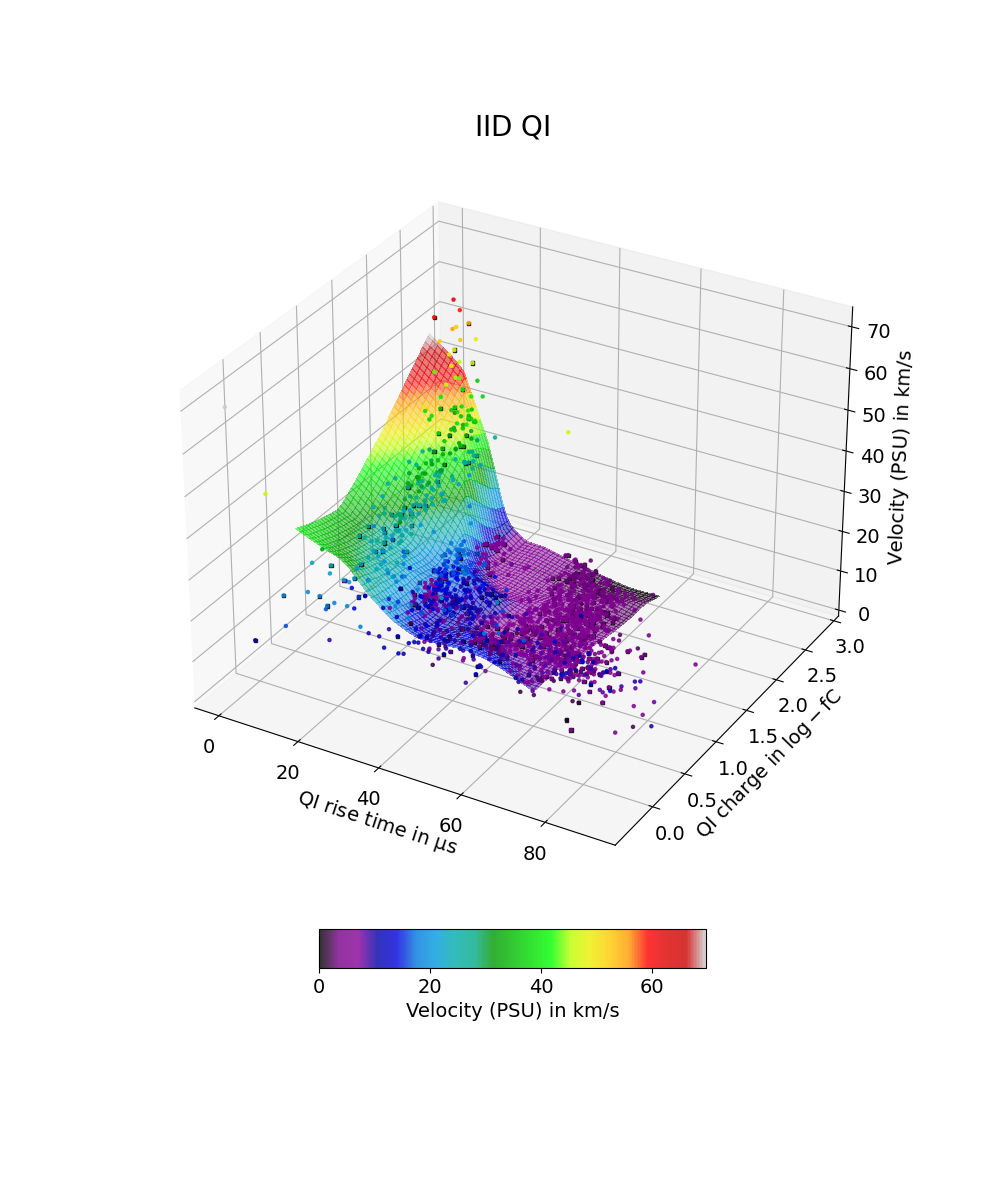

In [24]:
# Now we plot the 3D scatter + the resulting solution space
# Channel QI (you can replace it easily with other columns to get a "feeling" for other IID results
ch = "QI"

# 3D Plot
fig = plt.figure(figsize = (10, 12))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with log10 charges
sc = ax.scatter(iid_qi_cal_df[ch + '_TR'],
                iid_qi_cal_df[ch + '_LOG10_CHARGE'].values,
                iid_qi_cal_df['PSU_VEL'],
                c=iid_qi_cal_df['PSU_VEL'],
                cmap="nipy_spectral",
                vmin=0,
                vmax=np.max(iid_qi_cal_df['PSU_VEL']),
                marker='.',
                alpha=0.8,
                zorder=0)

ax.scatter(X_test[:,0], X_test[:,1], y_test, marker="s", alpha=0.8, s=5, color="black")

# Some titles and labels
ax.set_title(r'$\mathrm{IID\ ' + ch + '}$', fontsize=20)

ax.set_xlabel(r'$\mathrm{' + ch + '\ rise\ time\ in\ \mu s}$', fontsize=14)
ax.set_ylabel(r'$\mathrm{' + ch + '\ charge\ in\ log-fC}$', fontsize=14)
ax.set_zlabel(r'$\mathrm{Velocity\ (PSU)\ in\ km/s}$', fontsize=14)

ax.set_zlim(0, 1.05 * np.max(iid_qi_cal_df['PSU_VEL']))
ax.tick_params(labelsize=14)

# Add the regression plane
ax.plot_surface(rise_time_range,
                log_fc_range,
                pred_vel,
                cmap="nipy_spectral",
                linewidth=0,
                antialiased=False,
                alpha=0.5)

# Create a colorbar
cbar = fig.colorbar(sc,
                    shrink=0.5,
                    aspect=10,
                    orientation='horizontal',
                    pad=0.04)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(label=r'Velocity (PSU) in km/s',
               size=14)

# If you do not run the 3D plot interactively, you can un-comment the following line to 
#ax.view_init(90, 90)

plt.show()

## Outlook

Is the RMSE everywhere the same?

In [25]:
# Ok... we need the "correct" scale
_, rmse_scaled, mae_scaled = model.evaluate(X_train_scaled[X_train[:,0] > 80],
                                            y_train_scaled[X_train[:,0] > 80])

rmse = y_scaler.inverse_transform([[rmse_scaled]])
mae = y_scaler.inverse_transform([[mae_scaled]])

print(f"RMSE on test data in km/s: {rmse[0][0]}")
print(f"MAE on test data in km/s: {mae[0][0]}")

1/1 [==============================] - 0s 15ms/step - loss: 0.0922 - root_mean_squared_error: 0.3036 - mean_absolute_error: 0.2319
RMSE on test data in km/s: 12.87838324290644
MAE on test data in km/s: 12.208877451951304
